In [301]:
import numpy as np
import pandas as pd
from pyproj import Geod
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import haversine
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from math import sin, cos, sqrt, atan2, radians

In [302]:
train_data = pd.read_csv( "train.csv" )
test_data = pd.read_csv( "test.csv" )

In [303]:
# Utiliy functions

#Get distance between pairs of lat-lon points
wgs84_geod = Geod(ellps='WGS84')
def get_distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

In [304]:
def normalize(data):
    return ((data-data.min())/(data.max()-data.min()))


def process_data(data):
    # Calculating distance (m) based on longitude/latituides and adding it in a new column 'dist'
    data['dist'] = get_distance(data['pickup_latitude'].tolist(), data['pickup_longitude'].tolist(),
                                data['dropoff_latitude'].tolist(), data['dropoff_longitude'].tolist())
    
    data['dist'] = data['dist'] / 1000
    data['haversine_distance'] = data.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                          (r['dropoff_latitude'], r['dropoff_longitude'])), 
                                                                          axis=1)
    data['manhattan_distance'] = (abs(data.dropoff_longitude - data.pickup_longitude) +
                                  abs(data.dropoff_latitude - data.pickup_latitude))
    
    data['log_distance'] = np.log(data['dist'] + 1)
    data['log_haversine_distance'] = np.log(data['haversine_distance'] + 1)
    data['log_manhattan_distance'] = np.log(data.manhattan_distance + 1)
    
    data['sqr_distance'] = data['log_distance']**2
    data['sqr_haversine_distance'] = data['log_haversine_distance']**2
    data['sqr_manhattan_distance'] = data['log_manhattan_distance']**2
   
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
    data['pickup_minute_of_the_day'] = data.pickup_datetime.dt.hour*60 + data.pickup_datetime.dt.minute
    data['pickup_month'] = data.pickup_datetime.dt.month
    
    data['night_trip'] = [True if x < 7 else False for x in data['pickup_hour']]
    data['rush_hour'] = [True if 9 < x < 20 else False for x in data['pickup_hour']]
    data['weekday'] = [True if x < 5 else False for x in data['pickup_weekday']]
    
    data['no_passengers'] = data.passenger_count.map(lambda x: 1 if x == 0 else 0)
    data['one_passenger'] = data.passenger_count.map(lambda x: 1 if x == 1 else 0)
    data['few_passengers'] = data.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
    data['many_passengers'] = data.passenger_count.map(lambda x: 1 if x >= 5 else 0)
                      
    # Replacing N of store_and_fwd_flag with 0 and Y with 1
    data = data.replace({'N': 0, 'Y': 1})
    
    # Dropping columns no longer required
    data = data.drop(['pickup_latitude','pickup_longitude', 'pickup_datetime', 'pickup_weekday',
                      'dropoff_latitude','dropoff_longitude', 'store_and_fwd_flag', 'id'], axis=1)
     
    return data

In [305]:
# Hypothesis function
def hyp(theta, X):
    return np.dot(X, theta.T)  

# The loss function in our case is the sum of the squared error
def loss_func(theta, X, Y):
    return np.sum(((hyp(theta, X) - Y)**2) / (2 * X.shape[0]))

def get_graident(theta, X, Y):
    derivatives = []
  
    for i in range(0, X.shape[1]):
        derivatives.append(np.sum((hyp(theta, X) - Y) * X[:, i]) / X.shape[0])

    return np.array(derivatives)


def gradient_descent(X, Y, maxniter=20000):
    thetas = np.random.rand(X.shape[1],)
    alpha = 0.01
    costs = []
    
    for i in range(0, maxniter):
        thetas = thetas - (alpha * get_graident(thetas, X, Y))
        costs.append(loss_func(thetas, X, Y))
        
    return thetas, costs

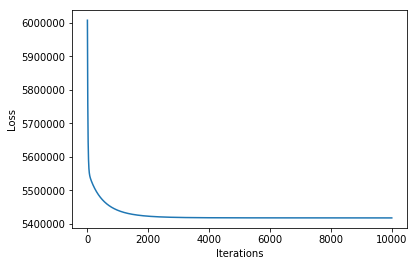

In [306]:
proc_data = process_data(train_data)
X = normalize(proc_data.drop('trip_duration', axis=1)).values
Y = proc_data['trip_duration'].values

max_iters = 10000
thetas, costs = gradient_descent(X, Y, max_iters)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(np.arange(0, max_iters), costs)

In [307]:
pred = hyp(thetas, normalize(process_data(test_data)))
submission = pd.DataFrame({'id':test_data['id'], 'trip_duration':pred})
submission.to_csv("kaggle_submission.csv", index=False)

submission['trip_duration'].describe()

count    30000.000000
mean       985.106911
std        586.254676
min       -266.054040
25%        600.263168
50%        855.761844
75%       1214.477377
max       5270.608444
Name: trip_duration, dtype: float64

In [308]:
# from scipy import stats
# temp = train_data[train_data.trip_duration <= np.percentile(train_data.trip_duration, 99)]

# fig, ax = plt.subplots(2,2,figsize=(20, 10), sharex=False, sharey = False)
# sns.despine(left=True)
# sns.distplot(temp['trip_duration'].values, label = 'pickup_latitude',color="g",bins = 100, ax=ax[0,0])

In [309]:
submission

,id,trip_duration
0,id1430318,975.202888
1,id3276964,567.374226
2,id2541342,1114.944625
3,id3582288,500.663412
4,id2976277,220.857277
5,id1856113,651.369214
6,id0712136,1231.649041
7,id2704634,932.409283
8,id2736446,212.126629
9,id3267520,990.697813


In [310]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist,...,pickup_minute_of_the_day,pickup_month,pickup_dayofyear,night_trip,rush_hour,weekday,no_passengers,one_passenger,few_passengers,many_passengers
0,id1430318,2,2016-03-22 18:50:33,1,-73.980049,40.780739,-73.959808,40.775421,N,1.807829,...,1130,3,82,False,True,True,0,1,0,0
1,id3276964,2,2016-04-02 18:28:19,5,-73.973427,40.761002,-73.968033,40.767941,N,0.895092,...,1108,4,93,False,True,False,0,0,0,1
2,id2541342,1,2016-03-10 22:16:01,1,-73.947975,40.778755,-73.940880,40.822464,N,4.890656,...,1336,3,70,False,False,True,0,1,0,0
3,id3582288,1,2016-05-18 15:42:46,1,-73.975685,40.754814,-73.981209,40.747417,N,0.944614,...,942,5,139,False,True,True,0,1,0,0
4,id2976277,1,2016-01-20 08:11:48,2,-73.953613,40.779270,-73.953087,40.775742,N,0.394361,...,491,1,20,False,False,True,0,0,1,0
